# Table of Contents
* [Truss 2D elements structure](#Truss-2D-elements-structure)
	* &nbsp;
		* [Problem 1: Mathematically state the optimization](#Problem-1:-Mathematically-state-the-optimization)
		* [Set up the problem in a programming language](#Set-up-the-problem-in-a-programming-language)
	* [Performing simulations for 100, 200 and 250 iterations.](#Performing-simulations-for-100,-200-and-250-iterations.)
		* [plot the final solution with deformation](#plot-the-final-solution-with-deformation)


# Truss 2D elements structure

Consider the truss structure below, proposed in the book of \cite{Christensen2009}, and minimize its compliance under a volume constraint.

\begin{figure}
\centerline{\includegraphics{Structure.png}}
\caption{\label{fig:structure} Structure to be optimized.}
\end{figure}

### Problem 1: Mathematically state the optimization

The problem for minimizing compliance in a 2D structure is the following

%% latex
\begin{equation}
(\mathbb{P}_{nf})\begin{cases}
DV= & \begin{pmatrix}x_{1}\\
x_{2}\\
\vdots\\
x_{n}
\end{pmatrix}\\
f(x) & \underset{x,u}{\min}\mathbf{F}^{T}u\\
s.t & \stackrel{n}{\sum}l_{j}x_{j}-V_{max}\leq 0\\
 & \mathbf{x}\in\chi=\{\mathbf{x}\in\mathbb{R}^{n}:x_{j}^{min}\leq x_{j}\leq x_{j}^{max}\},j=1,\ldots,n
\end{cases}
\end{equation}

Where $DV$ are the design variables $x_{j}$ (cross-sectional areas in this case), $n$ the number of bars, $l_{j}$ the length of bar $j$,  ,and Vmax is the maximum allowed volume of the truss. In general, $\mathbf{F}$ may very well depend on x, e.g. by including the weight of the bars. The matrix $\mathbf{K}(x)$ is the global stiffness matrix of the structure, and there a given lower and upper bounds.

### Set up the problem in a programming language

Python was proposed to solve this problem. The solution consist on two modules developed to solve the 2D truss structure problem of any size. The first module is about Finite Element Analysis solution of 2D trusses, and the second module deals with the visualization of the process. These modules are written in the _FEAtrussDP3Opt.py_ file.

In [1]:
# %load ./FEAtrussDP3Opt.py
#!/usr/bin/env python3
"""
Created on Tue Jul 24 12:05:58 2018
FEA class for trusses
@author: nikorose
"""

import numpy as np
import vtk
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from latex_envs.latex_envs import figcaption

class Vizualization():

    def __init__(self):
        pass
    def displayTruss(self, elemNodes,nodeCords, stress=None, Area=None, \
                     name="Quantity", displace=False, displacements=None, \
                     scale = 1.0):
        '''
        Function for calculating stiffness matrix, displacements, stresses of 2D trusses
        with the VTK libraries. Original code proposed by SukhbinderSingh.com    
        '''
        if displace == True:
            # If statement for displaying deformations only 
            # converting displacements into a 2D array
            #Adding the displacement to the coords
            if displacements.all():
                raise ValueError('No displacement found, did you forget stated them?')
            else:
                nodeCords =  np.reshape(displacements, (-1, 2)) * scale + nodeCords ## Note that the scale is put here 
            
        pts = vtk.vtkPoints()
     
        for x,y in nodeCords:
            pts.InsertNextPoint(x,y,0.0)
     
        lines=vtk.vtkCellArray()
        for ii,jj in elemNodes:
            lines.InsertNextCell(2)
            lines.InsertCellPoint(ii)
            lines.InsertCellPoint(jj)
   
        stdata = vtk.vtkDoubleArray()
        stdata.SetName(name)
        for val in stress:
            stdata.InsertNextValue(val)
      
        grid = vtk.vtkPolyData()
        grid.SetPoints(pts)
        grid.SetLines(lines)
     
        grid.GetCellData().SetScalars(stdata)
      
     
        mapper=vtk.vtkPolyDataMapper()
        mapper.SetInputData(grid)
        mapper.SetScalarRange(np.min(stress),np.max(stress))

        actor = vtk.vtkActor()
        actor.SetMapper(mapper)
     
        sbar = vtk.vtkScalarBarActor()
        sbar.SetLookupTable(mapper.GetLookupTable())
        sbar.SetTitle(name)
     
        ren = vtk.vtkRenderer()
     
        ren.AddActor2D(sbar)
        ren.AddActor(actor)
     
        renwin= vtk.vtkRenderWindow()
        renwin.AddRenderer(ren)
        renwin.SetSize(900,500)
      
        iren=vtk.vtkRenderWindowInteractor()
        iren.SetRenderWindow(renwin)
        iren.Initialize()
        renwin.Render()
        iren.Start()
        
    def visualizeAreas(self, elementNodes, nodes, AreaOpt, supports, force, scale, stress, linewidth, maxiter):
        '''
        A function to plot the results in terms of areas (width of the line) and in terms
        of Stresses (Blue is compression, red is tension).
        '''
        #Normalize stresses from 0 to 1
        Stress_norm = np.concatenate((stress-np.min(stress))/(np.max(stress)-np.min(stress)))
        colors = pl.cm.jet(Stress_norm)
        plt.figure()
        count = 0
        len_ele = elementNodes[2,0,1] - elementNodes[2,0,0]
        Areaviz =  (AreaOpt-np.min(AreaOpt))/(np.max(AreaOpt)-np.min(AreaOpt)) * 5.0 +0.1
        figcaption('Topology Opt. of a 2D truss Structure at {} iterations.'.format(maxiter), label="fig:{}".format(maxiter))
        for i in elementNodes:
            plt.plot(i[:,0], i[:,1], color= colors[count], linewidth = Areaviz[count])
            count += 1
#        plt.plot(nodes[force,0], nodes[force,1], marker="v", markersize=8, color="red")
        for e in supports:
            plt.plot(nodes[e,0], nodes[e,1], marker="*", markersize=8, color="blue")
        plt.axis('off')
        plt.annotate('force', xy=(nodes[force,0], nodes[force,1]), xytext=(nodes[force,0], nodes[force,1]+len_ele/2.0),
            arrowprops=dict(facecolor='red', shrink=0.05))
#        cbar = plt.colorbar(stress, ticks=[-1, 0, 1])
#        cbar.ax.set_yticklabels(['< -1', '0', '> 1'])# vertically oriented colorbar
        #plt.title('Topology Opt. of a 2D truss Structure at {} iterations.'.format(maxiter))
        plt.show()
        return 

class FEA():    
    '''
    Contains all the functions to perform a Finite element 
    Analysis of 2D trusses
    '''
    def structure2(self, Numx, Numy, Coord = 10.0):
        '''
        Build the element array, containing the coordinates in each element
        '''
        if Numx == 0 or Numy == 0:
            raise ValueError('The size of the matrix should be greater than zero')
        else:
            #Coordinates Matrix Building
            x = np.linspace(0, Numx*Coord, Numx+1)
            y = np.linspace(0, Numy*Coord, Numy+1)
            xnodes, ynodes = np.meshgrid(x, y, indexing= 'ij')
            nodes = np.flip(np.array(np.meshgrid(y, x, indexing= 'ij')).T.reshape(-1,2),1) # We'll always have two dims in this problem
            # Flip is for doing a mirror (I dont't it worked in that way) of the array
            coordinate_grid = np.array([xnodes, ynodes])
            Ny = 0
            GeneralElem = []
            while Ny <= Numy-1:
                Nx = 0
                GeneralElem += [[coordinate_grid[:,Nx,Ny], coordinate_grid[:,Nx,Ny+1]]] # elem 0 in the Y border
                while Nx <= Numx-1:
                    GeneralElem += [[coordinate_grid[:,Nx,Ny], coordinate_grid[:,Nx+1,Ny+1]]] #element 1
                    GeneralElem += [[coordinate_grid[:,Nx,Ny+1], coordinate_grid[:,Nx+1,Ny]]] # elem 2
                    GeneralElem += [[coordinate_grid[:,Nx,Ny+1], coordinate_grid[:,Nx+1,Ny+1]]] # elem 3
                    GeneralElem += [[coordinate_grid[:,Nx+1,Ny+1], coordinate_grid[:,Nx+1,Ny]]] # elem 4
                    if Ny == 0:
                        GeneralElem += [[coordinate_grid[:,Nx,Ny], coordinate_grid[:,Nx+1,Ny]]] # elem 5 in the borders
                    Nx += 1
                Ny += 1       
        return np.array(GeneralElem), nodes
    
    def indexation(self, elementNodes, nodes):
        '''Returns the element matrix but with the node indexation'''
        index = []
        for e in elementNodes:
            # Finding the common index in this search
            i11 = np.where(nodes[:,0] == e[0,0])
            i12 = np.where(nodes[:,1] == e[0,1])
            i21 = np.where(nodes[:,0] == e[1,0])
            i22 = np.where(nodes[:,1] == e[1,1])
            i1 = np.intersect1d(i11,i12)[0]
            i2 = np.intersect1d(i21,i22)[0]
            index.append([i1,i2])
        return np.array(index)
        
    def solution(self, GDof,prescribedDof,stiffness, force):
        '''function to find solution in terms of global displacements 
        by AJM Ferreira on his book FEA with Matlab
        '''
        activeDof=np.setdiff1d(np.arange(GDof),prescribedDof)
        U=np.linalg.solve(stiffness[np.ix_(activeDof,activeDof)],force[np.ix_(activeDof)]);
        displacements=np.zeros((GDof,1))
        displacements[np.ix_(activeDof)]= U
        return displacements
    
    def formStiffness2Dtruss(self,A, GDof, elementNodes,nodes, indices, E):
        '''
        The code was inspired by the book MATLAB 
        Codes for Finite Element Analysis by
        AJM Ferreira, Springer
        '''
        stiffness=np.zeros((GDof,GDof))
        count = 0
        for e in elementNodes:
            elemDof=np.array([indices[count,0]*2, indices[count,0]*2+1, indices[count,1]*2, indices[count,1]*2+1])
            count += 1
            # Take into account the order of the next substraction
            xa = e[0,0]-e[1,0]
            ya = e[0,1]-e[1,1]
            len_elem=np.sqrt(xa**2+ya**2)
            c=xa/len_elem
            s=ya/len_elem
            try:
                EA = E*A[0,count-1]
            except IndexError:
                EA = E*A[count-1] ## The optimization algorithm change np array to a list
            k1=(EA/len_elem)* np.array([[c*c,c*s,-c*c, -c*s],
                                        [c*s,s*s,-c*s ,-s*s],
                                        [-c*c,-c*s,c*c,c*s],
                                        [-c*s,-s*s,c*s,s*s]])
            stiffness[np.ix_(elemDof,elemDof)] +=k1
        return stiffness
    
    def outputDisplacementsReactions(self, displacements,stiffness,GDof,prescribedDof):
        '''
        Calculates the force reactions once the displacements are obtained
        '''
        F = np.dot(stiffness,displacements)
        reactions = F[prescribedDof.T][0]
#        print(np.hstack([prescribedDof, reactions[:]]))
        return reactions
    
    def stresses2Dtruss(self, elementNodes,indices, displacements,E):
        '''
        Calculates the stresses in each element
        '''
        sigma = np.zeros((elementNodes.shape[0],1))
        count = 0
        for e in elementNodes:
            elemDof=np.array([indices[count,0]*2, indices[count,0]*2+1, indices[count,1]*2, indices[count,1]*2+1])
#            xa=np.abs(e[0,0]-e[1,0])
#            ya=np.abs(e[0,1]-e[1,1])
            xa = e[1,0]-e[0,0]
            ya = e[1,1]-e[0,1]
            len_elem=np.sqrt(xa**2+ya**2)
            c=xa/len_elem
            s=ya/len_elem
            sigma[count] = (E/len_elem) * np.dot(np.array([-c,-s,c,s]),displacements[np.ix_(elemDof)])
            count += 1
        return sigma
    



Five functions were implemented and/or modified in order to accomplish the process, being inspired mostly by the codes proposed in \cite{Codes2009}:

- _structure2_ Build the element matrix in an array, containing the coordinates in each element.
- _indexation_ Returns the element matrix but with the node indexation.
- _solution_ Function to find solution in terms of global displacements. The code was based on the book of AJM Ferreira \cite{Codes2009}
- _formStiffness2Dtruss_ Build the Stiffness matrix of the entire problem.
- _outputDisplacementsReactions_ Calculates the force reactions once the displacements are obtained.
- _stresses2Dtruss_ Calculates the stresses in each element.

Another class was proposed for visualizing the answer, which are:

- _displayTruss:_     Function for calculating stiffness matrix, displacements, stresses of 2D trusses
    with the VTK libraries. Original code proposed by \cite{truss2015}.
- _visualizeAreas:_ A function to plot the results in terms of areas (width of the line) and in terms of Stresses (Blue is compression, red is tension).

Now, we are ready to execute the code as follows:

In [2]:
# =============================================================================
# Importing and Defining the libraries needed
# =============================================================================
import numpy as np
from FEAtrussDP3Opt import FEA, Vizualization
from scipy.optimize import minimize
from latex_envs.latex_envs import figcaption
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Setting the classes needed
FEM = FEA()
viz = Vizualization()

In [24]:
# =============================================================================
# Initial Variables statements
#  E: modulus of elasticity A: area of cross section L: length of bar 
# =============================================================================

rows = 8
cols = 4
elementNodes, nodeCoordinates = FEM.structure2(rows,cols,1)
stress= np.zeros(elementNodes.shape[0])
E=10; 
# Defining areas for each element
A = np.ones((1,elementNodes.shape[0]))
# Defining element_length of each element
len_elements= np.array([[np.sqrt((e[0,0]-e[1,0])**2+(e[0,1]-e[1,1])**2) for e in elementNodes]] )
Vmax = np.dot(A,len_elements.T)

In [25]:

# =============================================================================
#  for structure:  displacements: displacement vector # force : force vector 
#  stiffness: stiffness matrix 
# =============================================================================

numberElements=elementNodes.shape[0]
numberNodes=nodeCoordinates.shape[0]
xx=nodeCoordinates[:,0]
yy=nodeCoordinates[:,1]

GDof=2*numberNodes
#U=np.zeros((GDof,1))
force=np.zeros((GDof,1))
# applied load at node 2
appoint = (cols+1)*rows*2 + 1
force[appoint]=-1
prescribedDof=np.arange(cols*2+1)[np.newaxis].T;
index_elem =  FEM.indexation(elementNodes, nodeCoordinates)

In the following section the optimization problem stated in equation \ref{eq:1} is solved by the function _minimize_, included in the **Scipy** library.

In [26]:
# =============================================================================
#  Optimization Section
# =============================================================================
def write(Xi):
    file = open('results.txt','a+') 
    file.write(str(Xi)+'\n') 
        
def optim_fun(x, *args):
    '''
    The Scipy Library is used to implement a solution for a 
    optimization problem looking for a compliant reduction.
    '''
    GDof, elementNodes, nodeCoordinates, indices, E, prescribedDof, force, writing = args
    stiff = FEM.formStiffness2Dtruss(x, GDof, elementNodes,nodeCoordinates, indices, E)
    displ = FEM.solution(GDof,prescribedDof,stiff, force)
    g0 = np.dot(force.T,displ)
    # If writing is activated, it will append the result of every iteration in the file results
    # you'll have to erase the file on every running  in order to not overwriting the last simulation
    if writing:  write(x)
    return g0[0][0]

In [27]:
# Defining the optimization problem, settings and running
cons = ({'type': 'ineq', 'fun': lambda x:  Vmax[0] - np.dot(x[:],len_elements.T)[0]}) # Make sure that only 1D array comes out
bnds = tuple([(.1,4)]*A.shape[1])
arguments = (GDof, elementNodes, nodeCoordinates, index_elem, E, prescribedDof, force, False)
options={'gtol': 1e-5, 'disp': True, 'maxiter':50 }

res = minimize(optim_fun, A, args=arguments, method='SLSQP', jac=None, hess=None, hessp=None, bounds=bnds, constraints=cons, tol=None, callback=None, options=options)
AreaOpt = res.x
Maxiter = res.nit

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.7630108434890938
            Iterations: 51
            Function evaluations: 7242
            Gradient evaluations: 51


In [28]:
# =============================================================================
# Establishing boundary conditions and solution of the physical variables
# =============================================================================

stiffness= FEM.formStiffness2Dtruss(AreaOpt,GDof,elementNodes, nodeCoordinates, \
                                    index_elem, E)

# solution
displacements = FEM.solution(GDof, prescribedDof, stiffness, force)

# stresses at elements
Stresses = FEM.stresses2Dtruss(elementNodes, index_elem, displacements, E)

# output displacements/reactions
Reactions = FEM.outputDisplacementsReactions(displacements,stiffness,GDof,prescribedDof)

# compliance Calculation
g0 = np.dot(force.T,displacements)


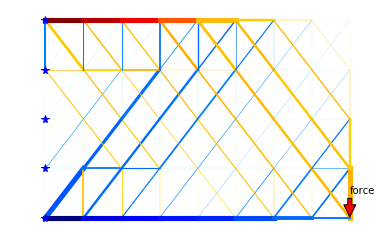

In [29]:
# =============================================================================
# Plotting the behavior of the optimization result
# =============================================================================
linewidth = 5.0
scale = 2.0
force_node = int((appoint-1)/2)
prescribed_in_nodes = [int(e/2) for e in range(0,len(prescribedDof),2)]
viz.visualizeAreas(elementNodes, nodeCoordinates, AreaOpt, prescribed_in_nodes,
                   force_node, scale, Stresses, linewidth, Maxiter)

## Performing simulations for 100, 200 and 250 iterations.

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.7563336663729482
            Iterations: 101
            Function evaluations: 14342
            Gradient evaluations: 101


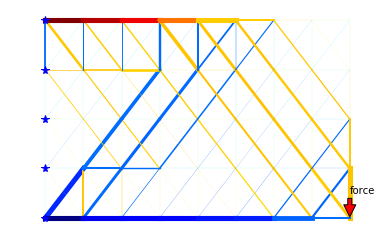

In [9]:
## changing the max iter parameter
options={'gtol': 1e-5, 'disp': True, 'maxiter':100 }
res100 = minimize(optim_fun, A, args=arguments, method='SLSQP', jac=None, hess=None, hessp=None, \
                  bounds=bnds, constraints=cons, tol=None, callback=None, options=options)
AreaOpt = res100.x
Maxiter = res100.nit

stiffness= FEM.formStiffness2Dtruss(AreaOpt,GDof,elementNodes, nodeCoordinates, index_elem, E)
displacements = FEM.solution(GDof, prescribedDof, stiffness, force)
Stresses = FEM.stresses2Dtruss(elementNodes, index_elem, displacements, E)
Reactions = FEM.outputDisplacementsReactions(displacements,stiffness,GDof,prescribedDof)
g0 = np.dot(force.T,displacements)
viz.visualizeAreas(elementNodes, nodeCoordinates, AreaOpt, prescribed_in_nodes,
                   force_node, scale, Stresses, linewidth, Maxiter)

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.7547842366674543
            Iterations: 201
            Function evaluations: 28542
            Gradient evaluations: 201


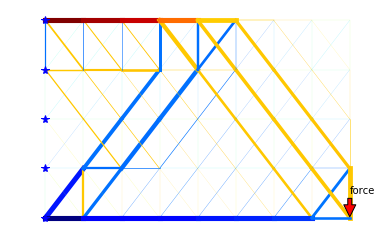

In [10]:
## changing the max iter parameter
options={'gtol': 1e-5, 'disp': True, 'maxiter':200 }
res200 = minimize(optim_fun, A, args=arguments, method='SLSQP', jac=None, hess=None, hessp=None, \
                  bounds=bnds, constraints=cons, tol=None, callback=None, options=options)
AreaOpt = res200.x
Maxiter = res200.nit

stiffness= FEM.formStiffness2Dtruss(AreaOpt,GDof,elementNodes, nodeCoordinates, index_elem, E)
displacements = FEM.solution(GDof, prescribedDof, stiffness, force)
Stresses = FEM.stresses2Dtruss(elementNodes, index_elem, displacements, E)
Reactions = FEM.outputDisplacementsReactions(displacements,stiffness,GDof,prescribedDof)
g0 = np.dot(force.T,displacements)
viz.visualizeAreas(elementNodes, nodeCoordinates, AreaOpt, prescribed_in_nodes,
                   force_node, scale, Stresses, linewidth, Maxiter)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7547691570248835
            Iterations: 206
            Function evaluations: 29253
            Gradient evaluations: 206


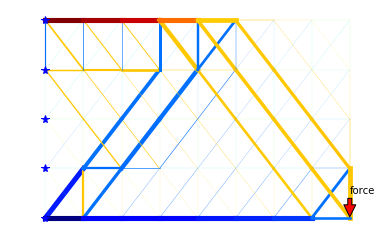

In [11]:
## changing the max iter parameter
options={'gtol': 1e-5, 'disp': True, 'maxiter':250 }
res250 = minimize(optim_fun, A, args=arguments, method='SLSQP', jac=None, hess=None, hessp=None, \
                  bounds=bnds, constraints=cons, tol=None, callback=None, options=options)
AreaOpt = res250.x
Maxiter = res250.nit

stiffness= FEM.formStiffness2Dtruss(AreaOpt,GDof,elementNodes, nodeCoordinates, index_elem, E)
displacements = FEM.solution(GDof, prescribedDof, stiffness, force)
Stresses = FEM.stresses2Dtruss(elementNodes, index_elem, displacements, E)
Reactions = FEM.outputDisplacementsReactions(displacements,stiffness,GDof,prescribedDof)
g0 = np.dot(force.T,displacements)
viz.visualizeAreas(elementNodes, nodeCoordinates, AreaOpt, prescribed_in_nodes,
                   force_node, scale, Stresses, linewidth, Maxiter)

As we can see in the Fig. \ref{fig:206}, the problem reached its convergence at this point, thus the 250 could not be reached.

### Plotting the final solution with deformation

In [13]:
# =============================================================================
# Trying to display deformation and Areas
# =============================================================================


viz.displayTruss(index_elem, nodeCoordinates, Stresses,Area=A, \
                 name='Stress (MPa)', displace=True, displacements=displacements, \
                 scale=0.1)

\begin{figure}[h]
\centerline{\includegraphics{deformations.png}}
\caption{\label{fig:displacement.png} Structure to be optimized.}
\end{figure}

# References

[<a id="cit-Christensen2009" href="#call-Christensen2009">Christensen2009</a>] !! _This reference was not found in library.bib _ !!

[<a id="cit-Codes2009" href="#call-Codes2009">Codes2009</a>] !! _This reference was not found in library.bib _ !!

[<a id="cit-truss2015" href="#call-truss2015">truss2015</a>] !! _This reference was not found in library.bib _ !!

